#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [3]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [4]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [5]:
online_channel= df.loc[df['Region'] == 'Canada',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.27,Canada
72,2011-06-18,Online,3578.27,Canada
103,2011-06-23,Online,3578.27,Canada
106,2011-06-24,Online,3578.27,Canada
136,2011-06-29,Online,3578.27,Canada
...,...,...,...,...
60393,2014-06-30,Online,21.98,Canada
60394,2014-06-30,Online,8.99,Canada
60395,2014-06-30,Online,21.98,Canada
60396,2014-06-30,Online,159.00,Canada


### Data Preprocessing

In [6]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [7]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,3578.2700
1,2011-06-18,3578.2700
2,2011-06-23,3578.2700
3,2011-06-24,3578.2700
4,2011-06-29,7652.3582
...,...,...
618,2014-06-26,434.8400
619,2014-06-27,334.5900
620,2014-06-28,484.0900
621,2014-06-29,457.5900


### Indexing with Time Series Data

In [8]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-06-18', '2011-06-23', '2011-06-24',
               '2011-06-29', '2011-07-01', '2011-07-12', '2011-07-18',
               '2011-07-19', '2011-07-22',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=623, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [9]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [10]:
y['2014':]

OrderDate
2014-01-01    3034.970323
2014-02-01    2767.759286
2014-03-01    3510.029032
2014-04-01    4539.277000
2014-05-01    4293.961290
2014-06-01     346.051667
Freq: MS, Name: Total_Sales, dtype: float64

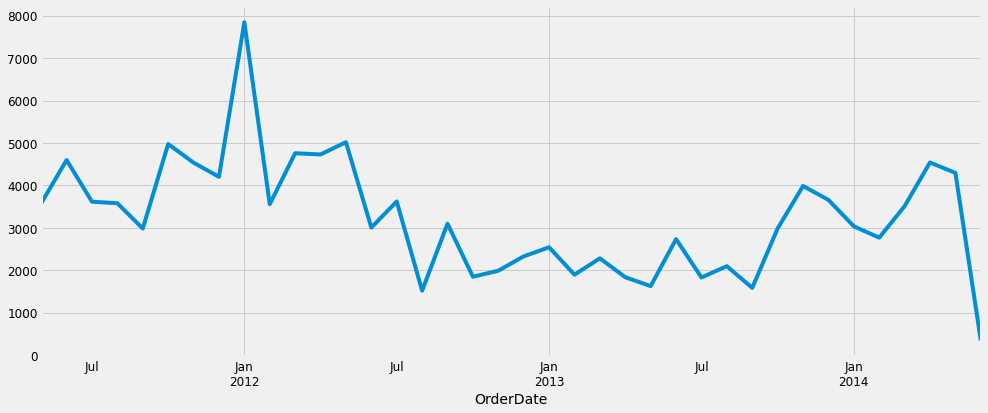

In [11]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

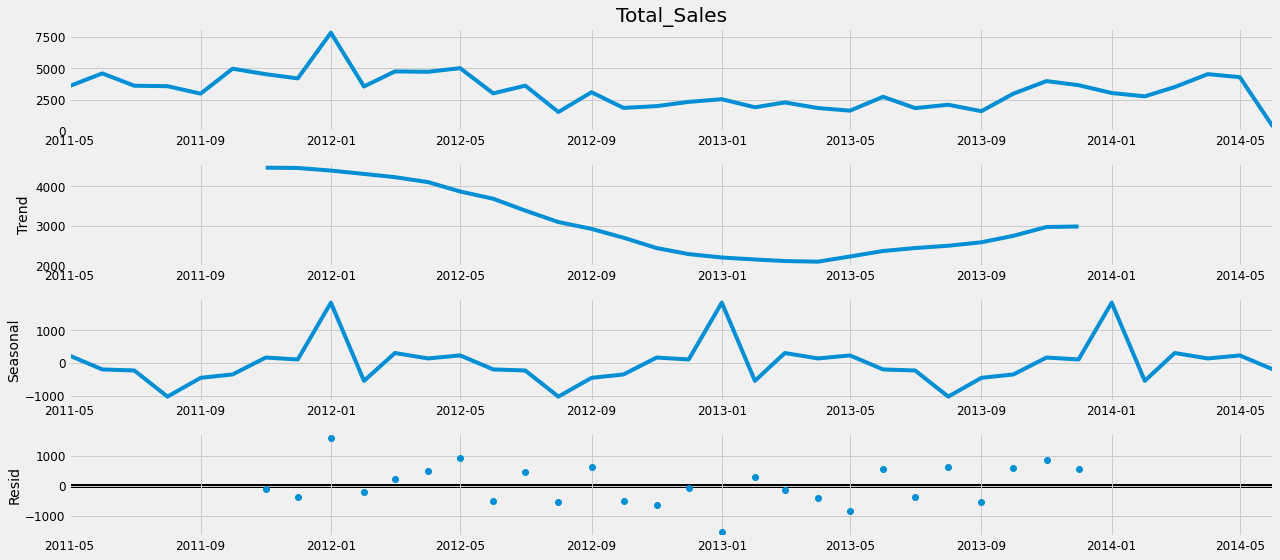

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [14]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:711.0612085204502
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:814.339920504271
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:457.35617254256886
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:225.24911610068744
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:464.47154740911685
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1065.9054294369807
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:246.92085804536129
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:226.1442059747598
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:673.7520091089376
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2159.8908366438745
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:437.8318846352034
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:210.61740619010482
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:460.95991070187654
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1280.117200018619
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:248.0197835187763
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:212.0512479746884
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:628.3443099722036
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1359.575878155275
ARI

 ### Fitting an ARIMA Time Series Model

In [15]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1581      0.600     -0.263      0.792      -1.334       1.018
ma.L1         -0.9968      2.409     -0.414      0.679      -5.718       3.725
ar.S.L12      -1.0255      0.291     -3.527      0.000      -1.595      -0.456
ma.S.L12       1.9790      2.672      0.741      0.459      -3.258       7.216
sigma2      2.803e+05   5.92e-06   4.73e+10      0.000     2.8e+05     2.8e+05


### Validating forecasts

In [16]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


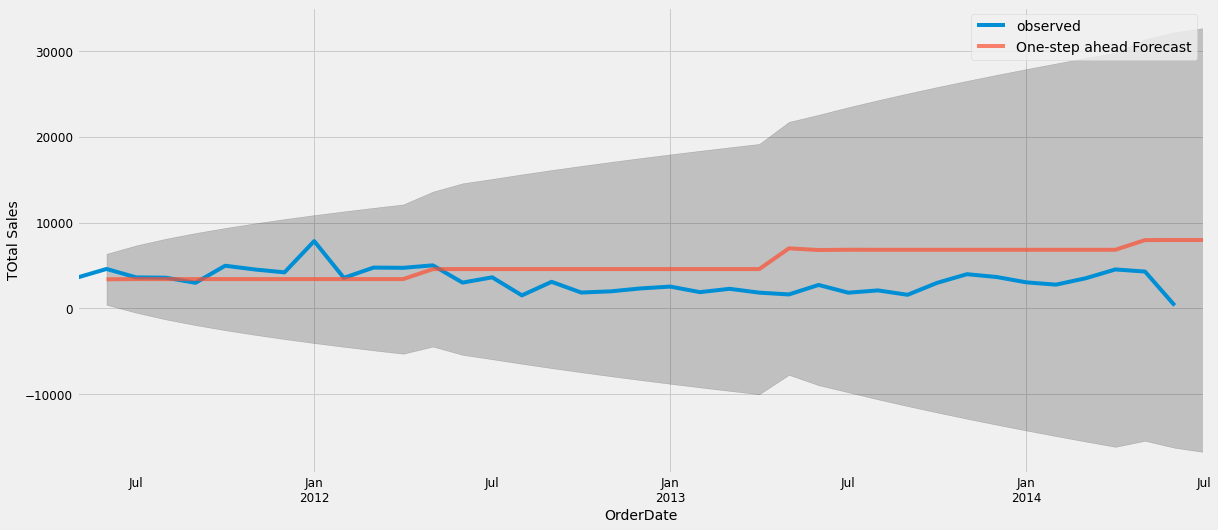

In [17]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 58151179.91


In [19]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 7625.69


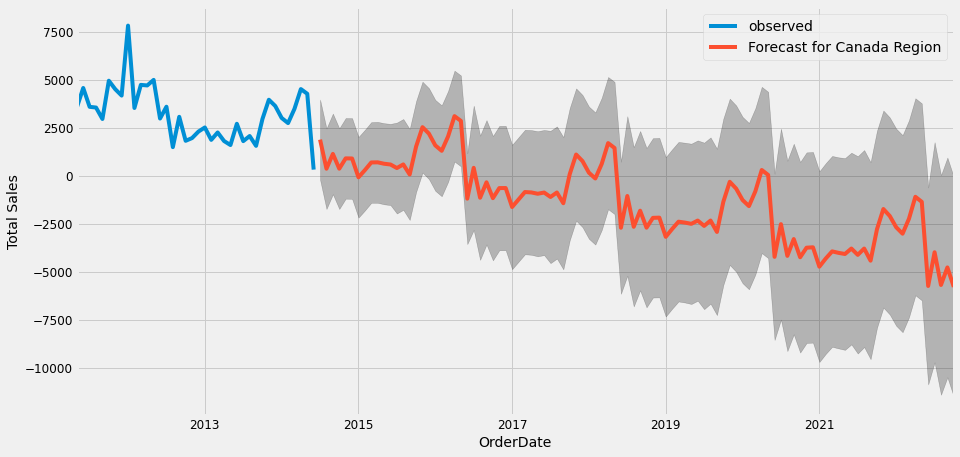

In [20]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for Canada Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()